# Convex optimisation

The goal of this lab is to manipulate some of the convex optimisation tools from [scipy.optimize](https://docs.scipy.org/doc/scipy/reference/optimize.html), which you will need to implement the machine learning algorithms we will see in the course.

## Imports

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image, set_matplotlib_formats 
set_matplotlib_formats('pdf', 'svg') # toggle vector graphics for a crisp plot!

## Introduction

Convex functions have the useful property that local minima are global minima.

To get a feel for scipy, we start with a simple example. We begin by defining a function to optimise, $$f_1(x) = (x - 1)^4 + x^2$$

In [4]:
# specify objective function
f1 = lambda x : (x - 1) ** 4 + x ** 2

We use Brent's method for optimisation. Brent's method does not require the function to optimize to be convex or derivable everywhere, and works as a combination of the secant method and parabola fittings, as follows:
1. Take a, b such that f'(a) < 0 and f'(b) > 0
2. Repeat:
  * Compute c = (a+b)/2
  * Compute the point d where the parabola that goes through a, b and c is minimal
  * If f'(d) < 10^{-sthg}: stop
  * Otherwise if f'(d) < 0: replace a with d, otherwise: replace b with d.
  
Illustration's source: Press, W. H., et al. (1992) "Numerical Recipes in Fortran, The Art of Scientific Computing", Cambridge University Press, Chapter 10.

In [5]:
from scipy.optimize import minimize_scalar

res = minimize_scalar(f1, method='brent')
print('xmin: %.02f, fval: %.02f, iter: %d' % (res.x, res.fun, res.nit))

xmin: 0.41, fval: 0.29, iter: 12


**Question:** Briefly describe the function output.

**Answer:** The function output gives the location of the minimum (xmin), the value of f1 (fval) and the number of iterations (iter) needed to be at this point

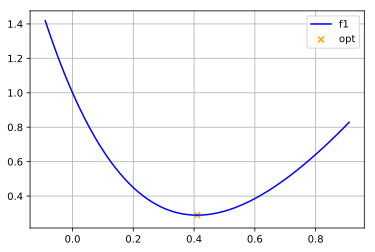

In [6]:
# plot curve
x = np.linspace(res.x - 0.5, res.x + 0.5, 100)
y = [f1(val) for val in x]
plt.plot(x, y, color='blue', label='f1')

# plot optima
plt.scatter(res.x, res.fun, color='orange', marker='x', label='opt')

plt.grid()
plt.legend(loc=1)

**N.B.** Optimisation, and particularly convex optimisation, plays a central role in machine learning. Although in this lab we focus on optimising simple functions, the same techniques will be used to optimise the high-dimensional loss functions of our learning machines.

#### Utility functions

In the following, we will be doing a lot of plotting, so we'll create a reusable function:

In [7]:
def plot_iterations(f, iterations, delta=0.1, box=1):
    xs = np.arange(-box, +box, delta)
    ys = np.arange(-box, +box, delta)
    X, Y = np.meshgrid(xs, ys)
    # create function mesh
    Z = np.array([[f(np.array([x, y])) for x in xs] for y in ys])
    # contour plot
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 2, 1)
    cd = ax.contour(X, Y, Z)
    # error plot
    ax.clabel(cd, inline=1, fontsize=10)
    ax.plot(iterations[:, 0], iterations[:, 1], color='red', marker='x', label='opt')
    ax = fig.add_subplot(1, 2, 2)
    ax.plot(range(len(iterations)), [f(np.array(step)) for step in iterations], 'xb-')
    ax.grid('on')
    ax.set_xlabel('iteration')
    ax.set_xticks(range(len(iterations)))
    ax.set_ylabel('f(x)')

__Question:__ What does `plot_iterations` do?

__Answer:__ it show 2 graphs for collected data during optimization: a contour plot and an decreasing error plot.

We'll also need a callback function between iterations. This function will be called after each iteration.

In [14]:
# specify callback function
def get_callback_function(data_list):
    def callback_function(x):
        data_list.append(x)
    return callback_function

## Smooth functions

When our cost function is smooth, we can use the tools of calculus for an open or closed-formed solution. We here focus on the former case, where our function is optimised incrementally in an iterative procedure. In general, we iterate until the gradient of our function is close to zero. We again start by specifing a function to minimise,

\begin{align}
f_2(\mathbf{x}) &= 2x_1^2 + 5x_2^2 \\ \notag
&= \mathbf{x}^T\mathbf{D}\mathbf{x} \notag
\end{align}

where $\mathbf{D} = \begin{bmatrix}
    2 & 0 \\
    0 & 5 \end{bmatrix}$ and $\mathbf{x} \in \mathbb{R}^{2}$.

In [8]:
f2 = lambda x : x.T.dot(np.diag([2, 5])).dot(x)

### Brute force search

First we'll try a trivial optimisation algorithm: [brute force](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.brute.html#scipy.optimize.brute). A brute force search tries every point in a fixed grid and retains the minimising value.

In [9]:
from scipy.optimize import brute
print(brute(f2, ranges=((-2, 2), (-2, 2))))

[ 1.51252956e-05 -1.18367293e-07]


**Question:** Comment briefly on the output.

**Answer:** The crud search should give as x1=0 and x2=0 as optimum values but the function didnt give this.

### First and second-order characterizations

A twice-differentiable convex function has a positive semi-definite Hessian $\mathbf{x} \mapsto \nabla^2 f(\mathbf{x})$ and is minimized where the gradient $\mathbf{x} \mapsto \nabla f(\mathbf{x})$ is equal to 0.

**Question:** Write a function `df2()` for the Jacobian (vector of partial derivatives) of `f2()` below:

In [10]:
def df2(x):
     return (np.diag([2, 5]) + np.diag([2, 5]).T).dot(x)

**Question:** Write a function `ddf2()` for the Hessian (matrix of second partial derivatives) of `f(2)` below:

In [12]:
def ddf2(x):
     return np.diag([4, 10])

**Question:** Prove our Hessian matrix, $\mathbf{H} = \partial^2 f / \partial\mathbf{x}^2$, is positive-definite everywhere.

**Answer:** derivative of f2(x) is equal to 4x1 + 10x2 which is strictily positive so the Hessian matrix is positive-definite everywhere. 

### Gradient descent methods

The workhorse of machine learning is gradient descent. Its variants are used to optimise a panoply of models from linear regression to deep neural nets. The gradient of mulivariate function at a point is the vector normal to the level curve. Gradient descent works by taking steps in the direction of the gradient,

$$\mathbf{x}_{k+1} = \mathbf{x}_{k} -\alpha\nabla f(\mathbf{x_k})$$

#### Newton's Method

Newton's method is a second order method, minimising a quadratic Taylor approximation to the objective function at each point. It thus combines the gradient and Hessian matrix,

$$\mathbf{x}_{k+1} = \mathbf{x}_{k} -\alpha\mathbf{H}_k^{-1}\mathbf{g}_k$$

where $\mathbf{g}_k = \nabla f(\mathbf{x_k})$ and $\mathbf{H}_k = \nabla^2 f(\mathbf{x_k})$. This is a multi-dimensional generalisation of the Newton root-finding method (here we are finding the root of the gradient). Newton's method typically involves a line search to optimise the size of the descent step, $\alpha$.

**Question:** Fill in the missing lines in the cell below to run [Newton's method](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.optimize.fmin_ncg.html) on our function. Note, in this implementation, the (sparse) Hessian is inverted by conjugate gradient descent.

In [15]:
from scipy.optimize import fmin_ncg

# specify initial point
x0 = [-1, 1]
# initialise callback data
ncg_data = [np.array(x0)]

# use fmin_ncg
res = fmin_ncg(f2, x0, fprime=df2, fhess=ddf2, callback=get_callback_function(ncg_data))

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 14
         Hessian evaluations: 7


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


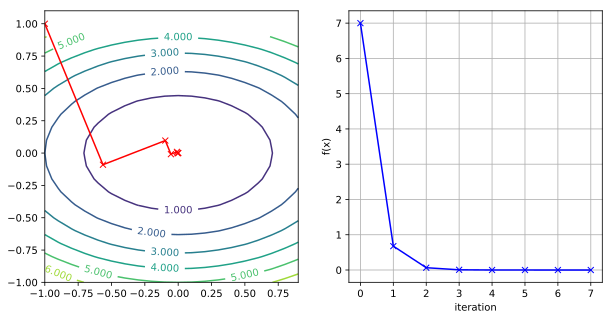

In [16]:
plot_iterations(f2, np.array(ncg_data))

**Question:** Newton's method uses a line search to optimise each descent step by choosing a step size $\alpha$ that optimises the descent direction, that is, $$\min_\alpha f(\mathbf{x_k} + \alpha \mathbf{d}_k),$$ where $\mathbf{d}_k = \nabla f({\mathbf{x}_k})$ is the descent direction. How does this show in the visualisation?

**Answer:** the descent steps are all at right angle. find $\alpha$ such that grandient of the function is equal to 0. The next descent direction(slope) is orthogonal to the curent direction.

#### Quasi-Newton: BFGS

[Broyden–Fletcher–Goldfarb–Shanno (BFGS)](https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm) is a quasi-Newton method. Because the Hessian is $\mathcal{O}(n^2)$ (a large expense at each iteration), BFGS aims to approximate the Hessian "on the fly" as a sum of rank one approximations. Note when space *and* runtime are a concern, *limited-memory* BFGS (l-BFGS) is further an option.

**Question:** Run the [scipy BFGS](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_bfgs.html#scipy.optimize.fmin_bfgs) algorithm on our function.

In [17]:
# specify initial point
x0 = [-1, 1]
# initialise callback data
bfgs_data = [np.array(x0)]
# TODO: import BFGS method from scipy.optimize
from scipy.optimize import fmin_bfgs
# TODO: run optimisation algorithm
res = fmin_bfgs(f2, x0, gtol=1e-5, fprime=df2, callback=get_callback_function(bfgs_data))

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 6


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


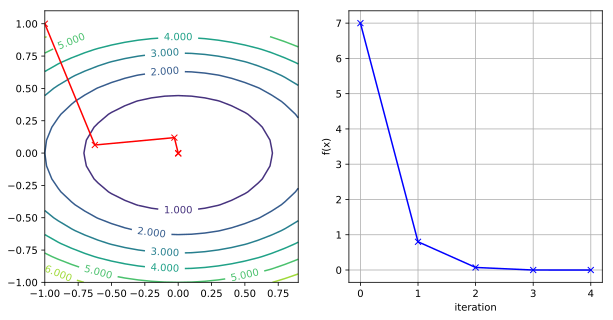

In [18]:
# Plot the iterations
plot_iterations(f2, np.array(bfgs_data))

**Question:** Verify that the norm of the gradient at the final point is close to 0.

In [21]:
# TODO calculate the norm of the gradient
df_norm = np.sqrt(np.dot(df2(res), df2(res)))
print("gradient is closed to 0: ",df_norm)

gradient is closed to 0:  4.336808689942018e-19


**Question:** What do you observe about the steps?

**Answer:** Hessian appriximation leads to approximate right angle descent steps.

#### Conjugate gradient method

The [conjugate gradient method](https://en.wikipedia.org/wiki/Conjugate_gradient_method) is an alternative to gradient descent. For a linear system $\mathbf{A}\mathbf{x} = \mathbf{b}$, this algorithm finds a solution as a linear combination of a set of *mutually conjugate vectors*, $\mathbf{p}_d$, such that,

$$\mathbf{x}^* = \sum_{d=1}^D \alpha_d\mathbf{p}_d$$ for the $D$ dimensions of the problem. The vectors are built determined one by one in a process similar to the [Gram Schmidt process](https://en.wikipedia.org/wiki/Gram%E2%80%93Schmidt_process). Particularly for a sparse system, a good approximate solution can be determined without constructing the entire conjugate set.

__Question:__ Run the conjugate gradient method `fmin_cg` on our function.

In [22]:
# specify initial point
x0 = [-1, 1]
# initialise callback data
cg_data = [np.array(x0)]
# TODO: import the conjugate gradient method from scipy.optimize
from scipy.optimize import fmin_cg
# TODO: run optimisation algorithm
res = fmin_cg(f2, x0, fprime=df2, callback=get_callback_function(cg_data))

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 3
         Function evaluations: 6
         Gradient evaluations: 6


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


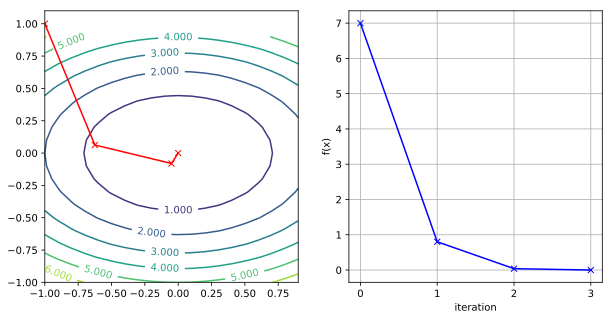

In [23]:
# Plot the iterations
plot_iterations(f2, np.array(cg_data))

**Question:** Try changing the initial point. Does anything change? Why?

**Answer:**  if we change initial point nothing change. It's because conjugate gradient has closed solution. 

# Bonus Question

## Non-smooth functions

Convex functions remain convex when we add linear constraints. A linear constraint restricts the solution space with an intersecting hyperplane. However, the smoothness property is lost, and calculus is no longer an option. To conceptualise the effect, imagine taking a spherical fruit such as an apple to be our unconstrained convex function. Then, adding a linear constraint corresponds to slicing it at some position at a fixed angle. Intuitively, the fruit remains convex after the cut, despite losing its smoothness (roundness).

#### Quadratic programming

A [quadratic programming (QP) problem](https://en.wikipedia.org/wiki/Quadratic_programming) is an optimisation problem of a quadratic function $\frac{1}{2}\mathbf{x^TQx} + \mathbf{c^Tx}$ subject to linear constraints, $\mathbf{Ax} \leq \mathbf{b}$. QP optimisation algorithms can be applied to the training of support vector machines (SVMs). Let's optimise the following quadratic program:

$$
\begin{array}{rl}
\text{minimise} & z = x_1^2 + 4x_2^2 - 32x_2 + 64 \\
\text{subject to} & x_1 + x_2 \leq 7 \\
& -x_1 + 2x_2 \leq 4 \\
& x_2 \leq 4 \\
& x_1, x_2 \geq 0
\end{array},
$$



**Question:** Specify the constraint matrices, $\mathbf{A}$ (coefficients), and $\mathbf{b}$ (constants).

In [24]:
# TODO Initialise A, b, and c as numpy arrays
A = np.array([[1, 1], [5, 2]])
b = np.array([5, 10])
c = np.array([-2, -1])

We create dictionary of constraints for use in the optimisation function:

In [25]:
cons = {'type':'ineq',
        'fun':lambda x: b - np.dot(A,x),
        'jac':lambda x: -A}

**Question:** Next, specify the components of the objective function: the matrix of quadratic coefficients $\mathbf{Q}$, the vector of linear coefficients $\mathbf{c}$, and the constant term, $c_0$.

In [26]:
# TODO: specify the matrix of quadratic coefficients, Q
Q = np.array([[2., 0.],
              [0., 8.]])

# TODO: specify the vector of linear coefficients, c
c = np.array([0, -32])

# TODO: specify the constant, c0
c0 = 64

**Question:** Write the objective function (loss).

In [27]:
def loss(x):
    # TODO: return loss given x
    return 0.5 * np.dot(x.T, np.dot(Q, x)) + np.dot(c, x) + c0

**Question:** Write the Jacobian function.

In [28]:
def jac(x):
    return np.dot(x.T, Q) + c
    

**Question:** Run scipy.optimize's minimize function on our QP problem.

In [29]:
from scipy.optimize import minimize

x0 = np.random.randn(2)
opt = {'disp':False}
res_cons = minimize(loss, x0, jac=jac, constraints=cons, method='SLSQP', options=opt)

print('\nConstrained:')
print(res_cons)

x1, x2 = res_cons['x']
f = res_cons['fun']


Constrained:
     fun: 2.823696831910638e-11
     jac: array([-7.57161103e-06,  1.49094586e-05])
 message: 'Optimization terminated successfully.'
    nfev: 6
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([-3.78580551e-06,  4.00000186e+00])


Finally, we will plot the solution in 3D axes. Feel free to change the code to adjust the view.

Text(0.5, 0, 'F')

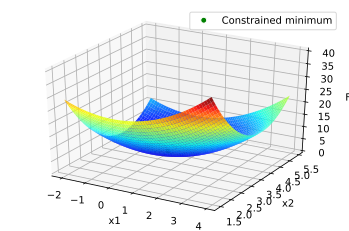

In [33]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
# plotting
xgrid = np.mgrid[-2:4:0.1, 1.5:5.5:0.1]
xvec = xgrid.reshape(2, -1).T
F = np.vstack([loss(xi) for xi in xvec]).reshape(xgrid.shape[1:])

ax = plt.axes(projection='3d')
ax.plot_surface(xgrid[0], xgrid[1], F, rstride=1, cstride=1,
                cmap=plt.cm.jet, shade=True, alpha=0.9, linewidth=0)
ax.plot3D([x1], [x2], [f], 'og', mec='w', label='Constrained minimum')
ax.legend(fancybox=True, numpoints=1)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('F')